# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

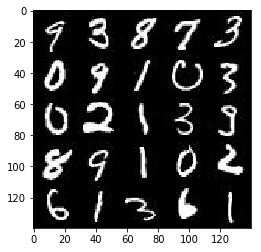

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

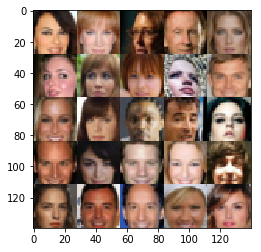

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/dra/anaconda3/envs/tensorflow3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Leaky ReLU, alpha sets the magnitude of the output for negative values
alpha = 0.02

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = images
        x1 = tf.layers.conv2d(x1, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # Flatten it
        flatten = x3
        flatten = tf.layers.flatten(flatten)
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim

        out = tf.tanh(logits)  
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Label smoothing of d_loss_real
    smooth = 0.05
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
losses = []

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    inputs_real, inputs_z, model_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    n_images = 9
    steps = 0
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # scale image, shoud be in range -1..1 not -0.5..0.5
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(
                    d_train_opt, 
                    feed_dict={inputs_real: batch_images, inputs_z: batch_z, model_learning_rate: learning_rate})
                _ = sess.run(
                    g_train_opt, 
                    feed_dict={inputs_real: batch_images, inputs_z: batch_z, model_learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, image_channels, data_image_mode)
                   
        saver.save(sess, './checkpoints/generator.ckpt')
        show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)
        
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6514... Generator Loss: 0.0406
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 1.9637... Generator Loss: 4.9865
Epoch 1/2... Discriminator Loss: 1.5450... Generator Loss: 1.4167
Epoch 1/2... Discriminator Loss: 0.9961... Generator Loss: 1.2259
Epoch 1/2... Discriminator Loss: 1.7292... Generator Loss: 2.5092
Epoch 1/2... Discriminator Loss: 1.6406... Generator Loss: 0.9952
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 1.3149
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 0.8980
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 1.5334


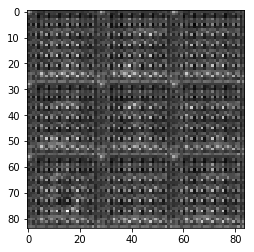

Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.5437... Generator Loss: 1.5263
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 1.2929
Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.9511
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 1.0835
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.0606
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 1.1296
Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 1.2674
Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.9574
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 1.1011


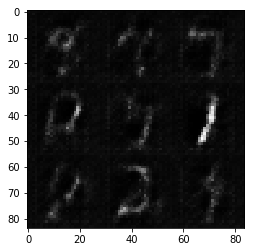

Epoch 1/2... Discriminator Loss: 1.5342... Generator Loss: 1.4382
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 0.5895
Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 0.4043
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.8301
Epoch 1/2... Discriminator Loss: 1.7025... Generator Loss: 0.2937
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.6137


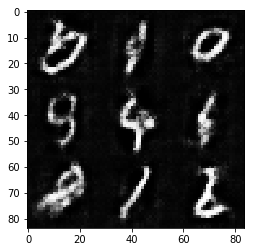

Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 0.4065
Epoch 1/2... Discriminator Loss: 1.5163... Generator Loss: 0.3756
Epoch 1/2... Discriminator Loss: 1.4874... Generator Loss: 0.4106
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.5704
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.4915
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.4411
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.5883... Generator Loss: 0.3318
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.6771


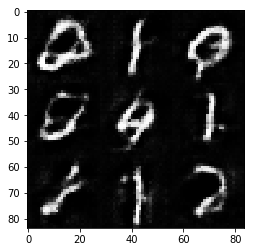

Epoch 1/2... Discriminator Loss: 1.6390... Generator Loss: 0.3262
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.6697... Generator Loss: 0.3078
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.7393
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.5236
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.3911
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.7603


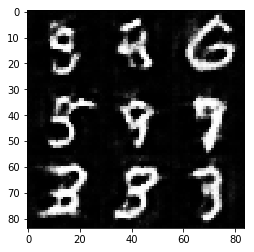

Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.6202
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 0.3760
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.4603
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.5399
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 0.5410
Epoch 2/2... Discriminator Loss: 1.5526... Generator Loss: 0.3929
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.8137
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.6266
Epoch 2/2... Discriminator Loss: 1.5181... Generator Loss: 1.5451


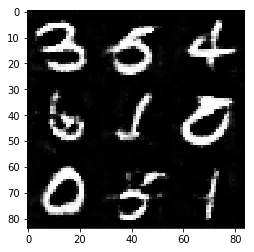

Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.6368
Epoch 2/2... Discriminator Loss: 2.0313... Generator Loss: 0.1965
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 1.1218
Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 1.1530... Generator Loss: 0.9118
Epoch 2/2... Discriminator Loss: 1.5701... Generator Loss: 1.5384
Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 0.6638


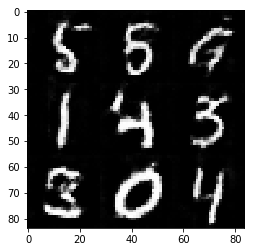

Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.4389
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 1.5306... Generator Loss: 1.6427
Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.7131
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 1.1589
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 1.2635
Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 1.4824... Generator Loss: 1.3696
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 1.0234
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 1.1430


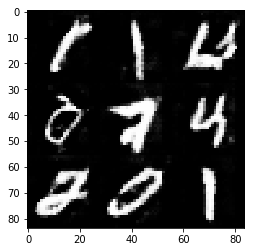

Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 1.5555... Generator Loss: 0.3502
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.8229
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 1.0914
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 1.6919... Generator Loss: 1.8473
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 0.6383


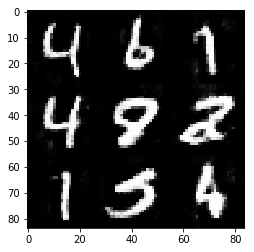

Epoch 2/2... Discriminator Loss: 1.3425... Generator Loss: 1.5460
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 1.8143... Generator Loss: 0.2586


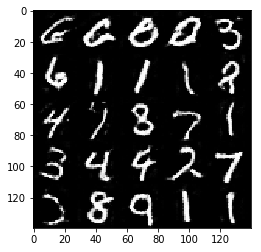

In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3

losses = []
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

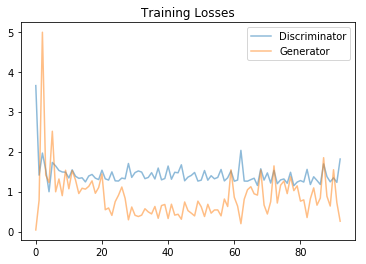

In [24]:
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
pyplot.title("Training Losses")
pyplot.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3226... Generator Loss: 0.1749
Epoch 1/1... Discriminator Loss: 1.6830... Generator Loss: 0.3356
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 1.8757... Generator Loss: 0.2683
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.9519
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 1.2478


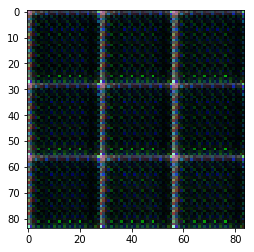

Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7650


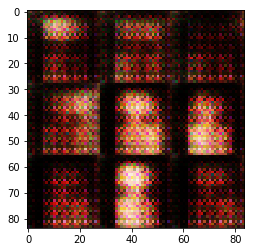

Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.8252


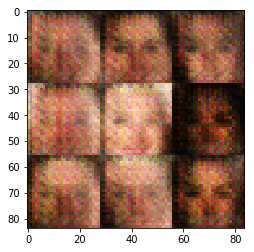

Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 1.6390
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.8267


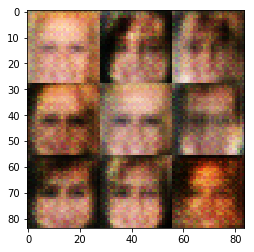

Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.9174


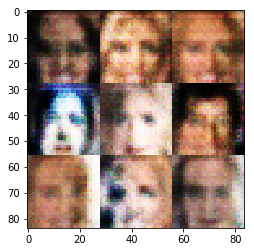

Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.7820... Generator Loss: 0.2842
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.8686
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 1.0651


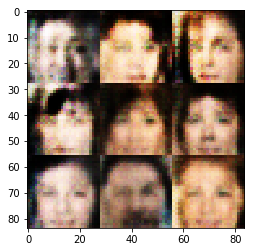

Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.8656
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 1.1620


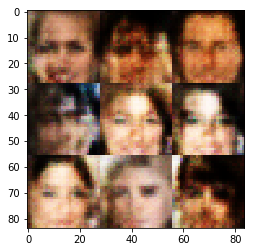

Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 2.3878
Epoch 1/1... Discriminator Loss: 1.6453... Generator Loss: 0.3334
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.9078... Generator Loss: 0.2501
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 1.5443
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.3508
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.4247


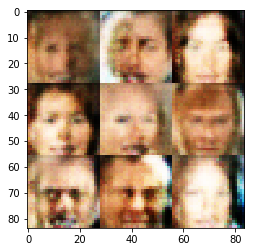

Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 2.4319
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 2.1288
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 2.7726
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1764


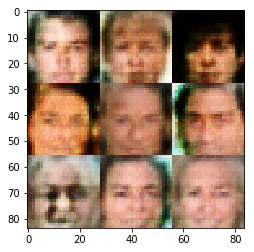

Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 0.8205


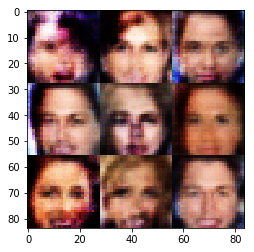

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.6325... Generator Loss: 0.3204
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 2.1983
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.3324
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.5282


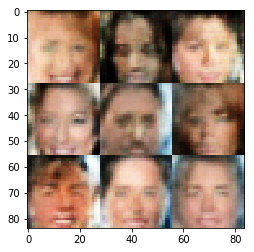

Epoch 1/1... Discriminator Loss: 1.8101... Generator Loss: 0.2664
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.1799
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.9891


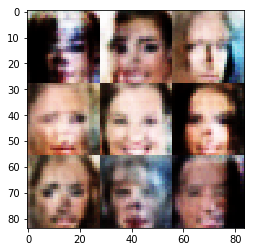

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 1.9203
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 1.4140
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.4716
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 1.4503
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 1.5302


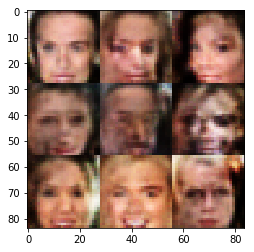

Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.8084... Generator Loss: 0.2618
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 0.9457


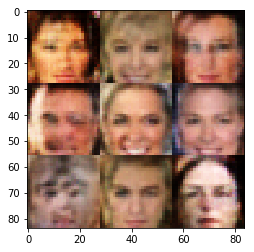

Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7378


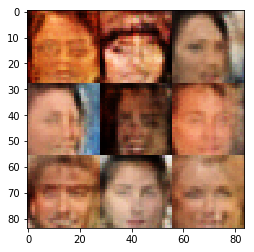

Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.3531
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.7228


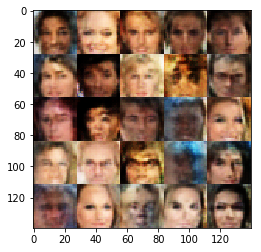

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4

losses = []
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

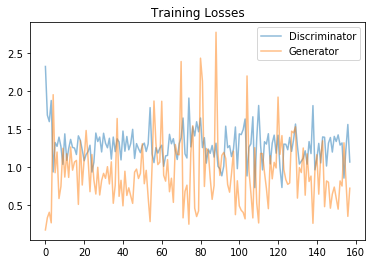

In [14]:
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
pyplot.title("Training Losses")
pyplot.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.